Consider the following equation
$$-\varepsilon^2 \Delta u + u = f, \quad x\in \Omega$$
$$u = 0, \quad x \in \partial \Omega.$$
We choose the true solution $u = \tanh(\frac{1}{\varepsilon}(x^2 - \frac{1}{4})) - \tanh(\frac{3}{4\varepsilon})$ on the interval $\Omega = [-1,1]$.

By FOSLS method, we have 
$$\sigma = - \varepsilon^2 \nabla u.$$
And the loss function
$$G(\sigma, u; f) = \|\text{div }\sigma + u -f \|_{0,\Omega}^2 + \|\frac{1}{\varepsilon}\sigma + \varepsilon \nabla u\|_{0,\Omega}^2 + \beta \|u\|^2_{0,\Omega}$$


In [25]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn, optim
from math import cosh
from math import tanh

In [27]:
global eps, dx, beta
eps, dx, beta = 0.01, .001, 1

In [28]:
def u_exact(x):
    y = (1/eps) * (x**2-1/4)
    return tanh(y) - tanh(3/(4*eps))

def sigma_exact(x):
    y = (1/eps) * (x**2 - 1/4)
    return  -(2*eps*x)/(cosh(y)**2)  
  
def f(x):
    y = (1/eps) * (x**2 - 1/4)
    return -2*(eps-4*x**2*tanh(y))*(1/cosh(y))**2 + u_exact(x)
  
def g(x):
    return torch.tensor([0.], requires_grad=True)

sq = lambda x: x ** 2
vsq = np.vectorize(sq)

In [29]:
# compute H1 norm of true u and sigma
L = -1.
R = 1.
test_set =  np.arange(L, R+dx, dx)
u = np.vectorize(u_exact)(test_set)
ud = -np.vectorize(sigma_exact)(test_set)/(eps*eps) 
u_h1 = np.sum(dx*(vsq(u) + eps*eps*vsq(ud)))
u_l2 = np.sum(dx*vsq(u))

sigma = np.vectorize(sigma_exact)(test_set)
sigmad = np.vectorize(f)(test_set) - u        
sigma_h1 = np.sum(dx*(vsq(sigma)/(eps*eps) + vsq(sigmad)))
sigma_l2 = np.sum(dx*vsq(sigma))

print('u: H1 norm square: %.6f, L2 norm square: %.6f ' %(u_h1, u_l2))
print('sigma: H1 norm square: %.6f, L2 norm square: %.6f ' %(sigma_h1, sigma_l2))
print('sigma: L2 norm square: %.6f ' %(sigma_l2))

u: H1 norm square: 3.985986, L2 norm square: 3.959321 
sigma: H1 norm square: 0.048009, L2 norm square: 0.000003 
sigma: L2 norm square: 0.000003 


In [30]:
class MuSigmaPde(nn.Module):
    def __init__(self, dimension, mesh = 32, neuron = 24):
        super(MuSigmaPde, self).__init__()

        self.xdim = dimension
        # Layer 1
        self.fc1mu = nn.Linear(dimension, mesh)
        self.fc1sig = nn.Linear(dimension, mesh)
        # Layer 2
        self.fc2mu = nn.Linear(mesh, neuron)
        self.fc2sig = nn.Linear(mesh, neuron)
        # Layer 3
        self.fc3mu = nn.Linear(neuron, neuron)
        self.fc3sig = nn.Linear(neuron, neuron)
        # Layer 4
        self.fc4mu = nn.Linear(neuron, 1)
        self.fc4sig = nn.Linear(neuron, dimension)

    def forward(self, x):   #Activation Function (Sigmoid)
        assert(len(x.shape) == 1 and x.shape[0] == self.xdim)
        y_mu =  torch.sigmoid(self.fc2mu(torch.sigmoid(self.fc1mu(x))))
        y_sig =  torch.sigmoid(self.fc2sig(torch.sigmoid(self.fc1sig(x))))
        mu =  self.fc4mu(torch.sigmoid(self.fc3mu(y_mu)))
        sigma = self.fc4sig(torch.sigmoid(self.fc3sig(y_sig)))
        return mu, sigma
      
    def net_grad(self, x):
        mu_center, sigma_center = self.forward(x)
        mu_forward, sigma_forward = self.forward(x - .5*dx)

        mu_grad_forward = (mu_center - mu_forward)/(.5*dx)
        sigma_grad_forward = (sigma_center - sigma_forward)/(.5*dx)
        return mu_grad_forward, sigma_grad_forward
    
    def loss_function_bulk(self, x):
        mu, sigma = self.forward(x)
        mu_grad, sigma_grad = self.net_grad(x) 
        LSE = torch.sum((eps*mu_grad + sigma/eps)**2) + (sigma_grad + mu - f(x))**2  #FOSLS
        return LSE 

    def loss_function_surf(self, x):
        mu, sigma = self.forward(x)
        # Boundary condition penalty
        BCP = beta * (mu - g(x))**2
        return BCP

In [46]:
model = MuSigmaPde(dimension =1, mesh = 32, neuron = 24)

In [47]:
sum([p.numel() for p in model.parameters()])

2962

In [48]:
loss_bulk_record, loss_surf_record = [], []

In [49]:
#h determines the size of quadrature points

h = .001
epochs = 20000
L, R = -1., 1.
bulk_set, surf_set =  np.arange(L, R, h), [L, R]
loss_bulk_record, loss_surf_record = [], []
print('bulk points number %d \nsurface points number %d\ntest points number %d\ndx for difference %.3g\ntrainging iteration %d' %(np.size(bulk_set), np.size(surf_set), np.size(test_set), dx, epochs))

bulk points number 2000 
surface points number 2
test points number 2001
dx for difference 0.001
trainging iteration 20000


In [56]:
def exp_lr_scheduler(optimizer, epoch, lr_decay=0.5, lr_decay_epoch=5000):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""
    if epoch % lr_decay_epoch:
        return optimizer
    if epoch == 0:
        return optimizer
    
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
    return optimizer

optimizer = optim.Adam(model.parameters(), lr = 0.01)


In [ ]:
tic()
local_min = 0.05
for j in range(epochs):
    loss_bulk = torch.zeros(1)
    loss_surf = torch.zeros(1)

    for point in bulk_set:
        x = torch.tensor([point+ 0.5*dx])
        loss_bulk += h*model.loss_function_bulk(x)
               
    for point in surf_set:
        x = torch.tensor([point])
        loss_surf += model.loss_function_surf(x)

    # record each loss
    loss_bulk_record.append(loss_bulk.data[0])
    loss_surf_record.append(loss_surf.data[0])
       
    loss = loss_bulk + loss_surf
    print('Train Epoch: {}, Loss: {:.6f}, loss bulk: {:.6f}, loss surf: {:.6f}'.format(j, loss.item(), loss_bulk.item(), loss_surf.item()))
    optimizer.zero_grad()
    #exp_lr_scheduler(optimizer, j)
    if loss.item() < local_min:
        print('updating the parameters')
        local_min = loss.item()
        torch.save(model.state_dict(),'./singular_sigmoid')
    
    loss.backward()
    optimizer.step()
    
toc()    

In [71]:
model.load_state_dict(torch.load('./singular_sigmoid'))
mu_err_h1 = torch.zeros(1)
sigma_err_h1 = torch.zeros(1)
bdd_err = torch.zeros(1)
mu_err_l2 = torch.zeros(1)
sigma_err_l2 = torch.zeros(1)
mu_err_semi = torch.zeros(1)
    
test_set =  np.arange(L, R+dx, dx)

for point in test_set:

    x = torch.tensor([point+ 0.5*dx])
    mu, sigma = model(x)
    mu_grad, sigma_grad = model.net_grad(x)

    # esitmate H1 norm error
    mu_diff = (mu_grad + (1/eps)**2 * sigma_exact(x))**2
    sigma_diff = (sigma - sigma_exact(x))**2 + (sigma_grad - f(x) + u_exact(x))**2
    mu_err_h1 += dx*mu_diff
    sigma_err_h1 += dx*sigma_diff

    # estimate L2 norm error
    mu_err_l2 += dx*(mu - u_exact(x))**2
    sigma_err_l2 += dx*(sigma - sigma_exact(x))**2
    
    # estimate H1 semi norm  error
    mu_err_semi += dx*(mu - u_exact(x))**2 + dx*eps*eps*((mu_grad + (1/eps)**2 * sigma_exact(x))**2)

mu_err_l2_relative = (mu_err_l2/u_l2)**(1/2)

mu_err_semi_relative = (mu_err_semi/u_h1)**(1/2)

sigma_err_l2_relative = (sigma_err_l2/sigma_l2)**(1/2)
G_rel = local_min**(1/2)/((u_h1 + sigma_h1)**(1/2))

print('u: L2_rel: {:.6f}, H1_semi_rel: {:.6f}'.format( mu_err_l2_relative.item(), mu_err_semi_relative.item()))
print('sigma: L2_rel: {:.6f}\n'.format(sigma_err_l2_relative.item()))
print('G_rel: {:.6f}\n'.format(G_rel.item()))

u: L2_rel: 0.001403, H1_semi_rel: 0.001711
sigma: L2_rel: 0.211490

G_rel: 0.003766



In [72]:
points = test_set
yt = np.vectorize(u_exact)(points)
y_diff = np.vectorize(sigma_exact)(points)
ymu = np.zeros_like(points)
ysig = np.zeros_like(points)
for i in range(len(points)):
    ymu[i], ysig[i] = model(torch.tensor([points[i]]))
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


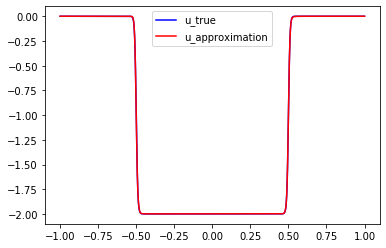

In [73]:
plt.plot(points, yt, color = 'b', label = 'u_true')
plt.plot(points, ymu, color = 'r', label = 'u_approximation')
plt.legend()           

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


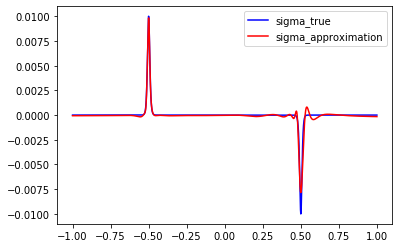

In [76]:
plt.plot(points, y_diff, color = 'b', label = 'sigma_true')
plt.plot(points, ysig, color = 'r', label = 'sigma_approximation')
plt.legend()

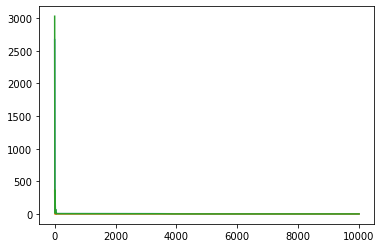

In [71]:
num = np.arange(1, len(loss_bulk_record)+1, 1)
plt.plot(num, loss_bulk_record)
plt.plot(num, loss_surf_record)
plt.plot(num, np.add(loss_bulk_record , loss_surf_record))
plt.show()

In [116]:
torch.save(model.state_dict(),'./singular_perturbed_sigmoid')
